In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from collections import Counter

In [57]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import optuna
import pickle

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
df = pd.read_csv('completeSpamAssassin.csv')
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [61]:
df.shape

(6046, 3)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


In [63]:
df.isnull().sum()

Unnamed: 0    0
Body          1
Label         0
dtype: int64

In [123]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [122]:
a = df.isnull().sum()
print((np.array(a)))
sum(np.array(a))

[0 0 0 0 0 0]


0

In [64]:
df.duplicated().sum()

0

In [65]:
df.dropna(inplace=True)

In [66]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [67]:
df.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [68]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\tarunraghav
[nltk_data]     srikanth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [69]:
df['char'] = df['Body'].apply(len)
df['words'] = df['Body'].apply(lambda x:len(nltk.word_tokenize(x)))
df['sentences'] = df['Body'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [70]:
df.head()

,Body,Label,char,words,sentences
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,12
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,5
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,4
3,##############################################...,1,2863,690,35
4,I thought you might like these:\n1) Slim Down ...,1,641,108,4


# EDA

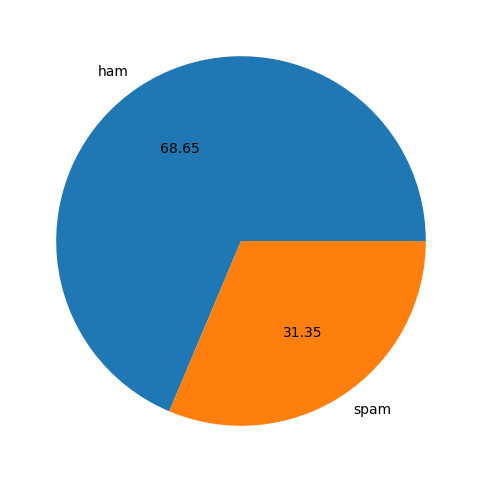

In [71]:
plt.figure(figsize=(12,6))
plt.pie(df['Label'].value_counts(), labels=['ham', 'spam'], autopct='%0.2f')
plt.show()

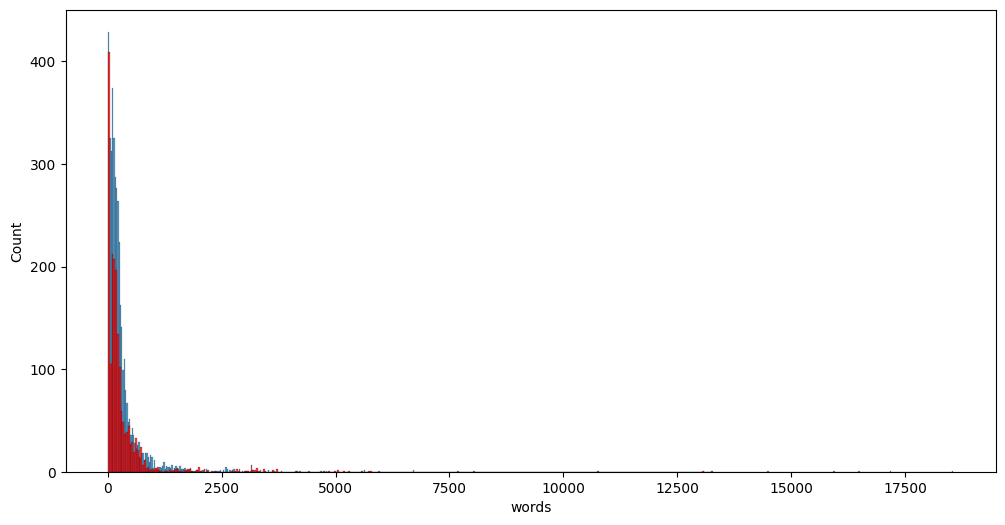

In [72]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['Label'] == 0]['words'])
sns.histplot(df[df['Label'] == 1]['words'], color='red')
plt.show()

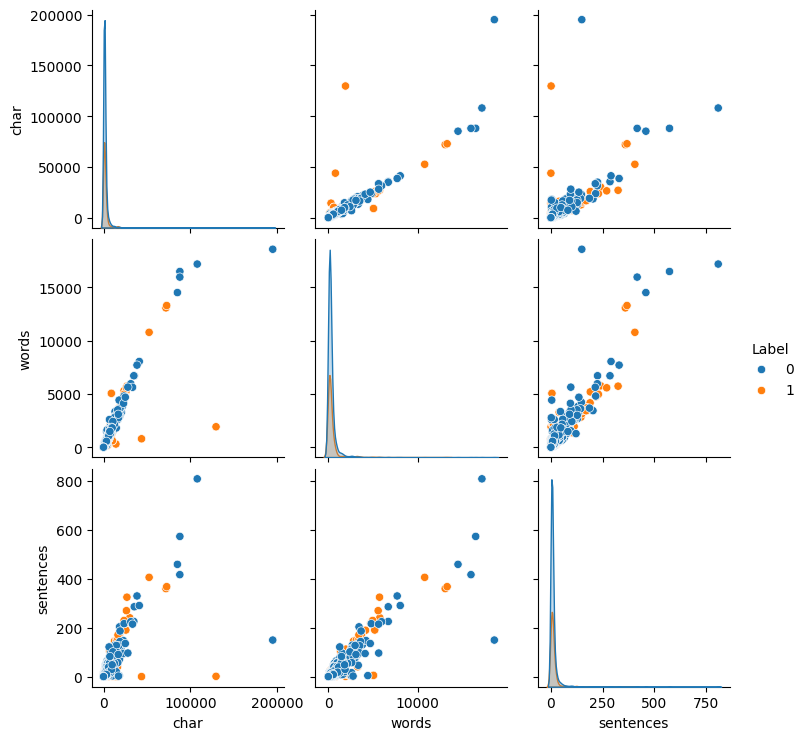

In [73]:
sns.pairplot(df, hue='Label')
plt.show()

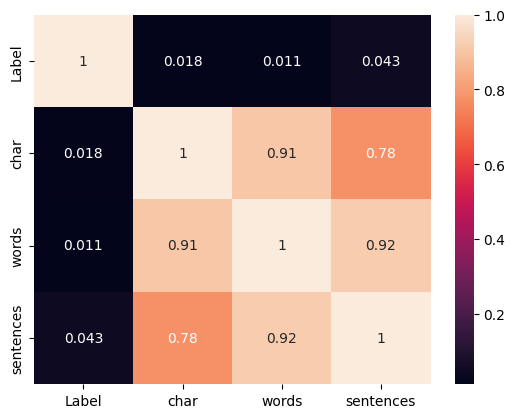

In [74]:
correlate = ['Label', 'char', 'words', 'sentences']

sns.heatmap(df[correlate].corr(), annot=True)
plt.show()

In [75]:
def text_processing(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    stemmer = SnowballStemmer('english')
    for i in text:
        y.append(stemmer.stem(i))

    return " ".join(y)

In [76]:
df['clean_text'] = df['Body'].apply(text_processing)

In [77]:
df.head()

,Body,Label,char,words,sentences,clean_text
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,12,save up to 70 on life insur whi spend more tha...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,5,1 fight the risk of cancer http slim down guar...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,4,1 fight the risk of cancer http slim down guar...
3,##############################################...,1,2863,690,35,adult club offer free membership instant acces...
4,I thought you might like these:\n1) Slim Down ...,1,641,108,4,i thought you might like these 1 slim down gua...


In [124]:
print(type(df['Body']))

<class 'pandas.core.series.Series'>


# word cloud

In [78]:
from wordcloud import WordCloud
wc = WordCloud(width=1000, height=500, min_font_size=10, background_color='black')

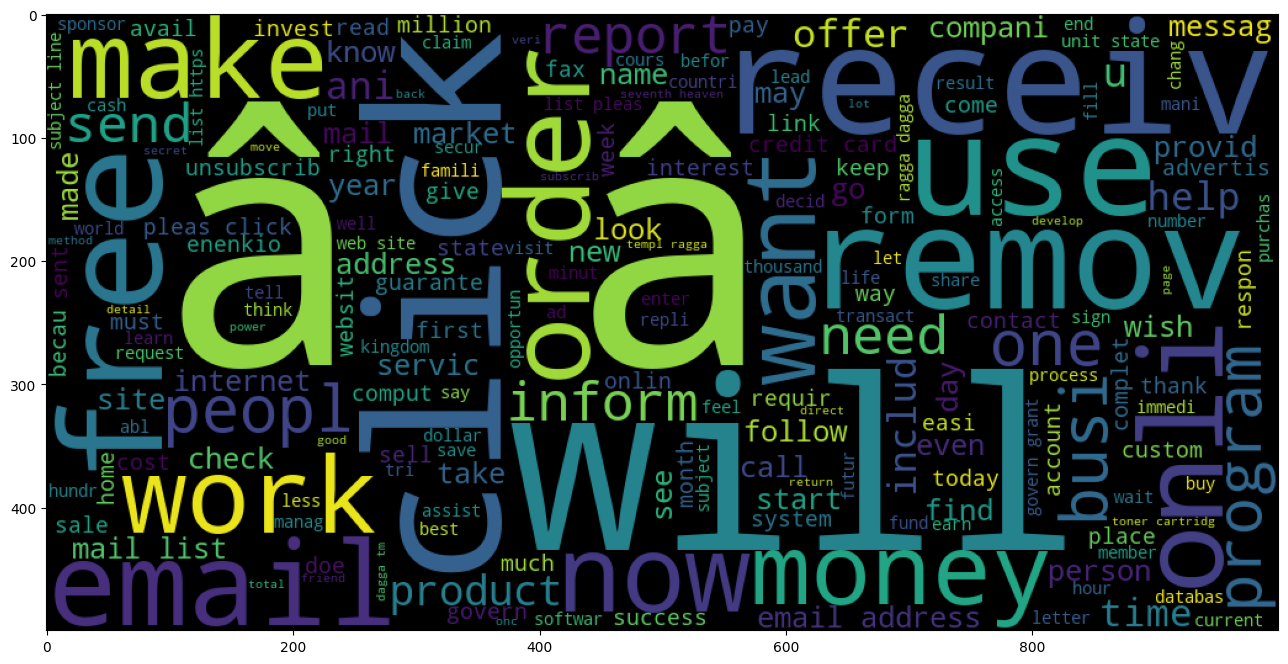

In [79]:
spam_wc = wc.generate(df[df['Label'] == 1]['clean_text'].str.cat(sep=' '))

plt.figure(figsize=(20, 8))
plt.imshow(spam_wc)

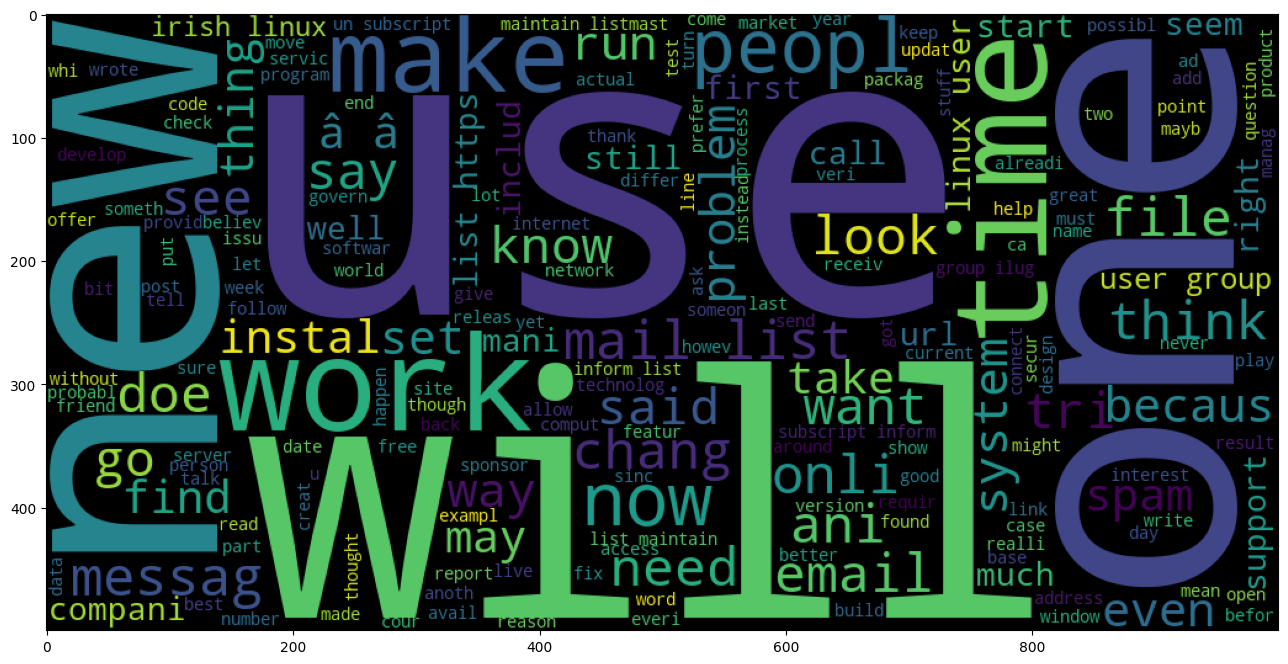

In [80]:
ham_wc = wc.generate(df[df['Label'] == 0]['clean_text'].str.cat(sep=' '))

plt.figure(figsize=(20, 8))
plt.imshow(ham_wc)

In [81]:
# creating a list of all the words in processed spam emails

spam_corpus = []
for mail in df[df['Label'] == 1]['clean_text'].tolist():
    for word in mail.split():
        spam_corpus.append(word)

len(spam_corpus)

473189

In [82]:
pd.DataFrame(Counter(spam_corpus).most_common(50))[1]

0     16419
1     14813
2     11349
3     10992
4     10061
5      8072
6      7556
7      6887
8      6412
9      6101
10     5199
11     4975
12     3503
13     3438
14     3274
15     3251
16     3172
17     3170
18     3108
19     3106
20     2825
21     2711
22     2679
23     2614
24     2421
25     2356
26     2253
27     2165
28     2162
29     2097
30     2080
31     1923
32     1918
33     1902
34     1742
35     1719
36     1639
37     1604
38     1602
39     1585
40     1518
41     1442
42     1428
43     1408
44     1386
45     1369
46     1364
47     1352
48     1350
49     1337
Name: 1, dtype: int64

In [83]:
pd.DataFrame(Counter(spam_corpus).most_common(50))

,0,1
0,the,16419
1,to,14813
2,and,11349
3,you,10992
4,of,10061
5,a,8072
6,â,7556
7,your,6887
8,for,6412
9,in,6101


In [84]:
# plt.figure(figsize=(20, 8))
# # data = (Counter(spam_corpus).most_common(50)[0], Counter(spam_corpus).most_common(50)[1])
# # sns.barplot(data=data)
# data=pd.DataFrame(Counter(spam_corpus).most_common(50))
# data.columns=['words', 'occurences']
# plt.bar(pd.DataFrame(Counter(spam_corpus).most_common(50)[0]), pd.DataFrame(Counter(spam_corpus).most_common(50)[1]))
# # plt.xticks(rotation='vertical')
# plt.show()

# # data.head()

In [86]:
# plt.figure(figsize=(20,8))
# sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(50))[0],pd.DataFrame(Counter(spam_corpus).most_common(50))[1])
# plt.xticks(rotation='vertical')
# plt.show()

In [87]:
ham_corpus = []
for mail in df[df['Label'] == 0]['clean_text'].tolist():
    for word in mail.split():
        ham_corpus.append(word)

len(ham_corpus)

944650

In [93]:
pd.DataFrame(df['clean_text'])

,clean_text
0,save up to 70 on life insur whi spend more tha...
1,1 fight the risk of cancer http slim down guar...
2,1 fight the risk of cancer http slim down guar...
3,adult club offer free membership instant acces...
4,i thought you might like these 1 slim down gua...
...,...
6041,empti
6042,insignific matter heavili overemphasis by hugh...
6043,in this reader write extens search dumb messag...
6044,empti


In [94]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(df['clean_text']).toarray()
y = df['Label'].values

In [95]:
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,...,36895,36896,36897,36898,36899,36900,36901,36902,36903,36904
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

# model selection

In [104]:
gnb = GaussianNB()
mnb = MultinomialNB()
rfc = RandomForestClassifier(n_estimators=50, random_state=0)
xgb = XGBClassifier(n_estimators=50, random_state=0)

In [105]:
classifiers = {
    'GaussianNB': gnb,
    'MultinomialNB' : mnb,
    'RandomForest': rfc,
    'XGB': xgb,
}

# creating a function to train list of algorithms and give accuracy , precision score

In [106]:
def train_classifier(classifiers, xtrain, xtest, ytrain, ytest):
    classifiers.fit(xtrain, ytrain)

    ypred = classifiers.predict(xtest)

    accuracy = accuracy_score(ytest, ypred)
    precision = precision_score(ytest, ypred)

    return accuracy, precision

In [110]:
accuracy_scores = []
precision_scores = []

for name, classifier in classifiers.items():
    current_accuracy, current_precision = train_classifier(classifier, xtrain, xtest, ytrain, ytest)

    print("For: ",name)
    print("Accuracy: ", current_accuracy)
    print("Precision: ", current_precision)
    print("-"*50)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For:  GaussianNB
Accuracy:  0.9073614557485525
Precision:  0.8324873096446701
--------------------------------------------------
For:  MultinomialNB
Accuracy:  0.8635235732009926
Precision:  0.8718861209964412
--------------------------------------------------
For:  RandomForest
Accuracy:  0.9404466501240695
Precision:  0.8911917098445595
--------------------------------------------------
For:  XGB
Accuracy:  0.9478908188585607
Precision:  0.8858560794044665
--------------------------------------------------


In [113]:
def objective_bnb(trial):
    alpha = trial.suggest_categorical('alpha', [0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3])
    binarize = trial.suggest_categorical('binarize', [0, 0.1, 0.2, 0.3])

    bnb = BernoulliNB(alpha=alpha, binarize=binarize)

    return cross_val_score(bnb, xtrain, ytrain, n_jobs=-1, verbose=0, scoring='precision').mean()

In [114]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_bnb, n_trials=18)

trial = study.best_trial

print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-08-17 17:12:53,593] A new study created in memory with name: no-name-ab8543c3-4deb-492f-8437-91e525be6ab7
[I 2024-08-17 17:13:39,919] Trial 0 finished with value: 0.0 and parameters: {'alpha': 0.9, 'binarize': 0.3}. Best is trial 0 with value: 0.0.
[I 2024-08-17 17:14:11,173] Trial 1 finished with value: 0.9961450397568793 and parameters: {'alpha': 1.3, 'binarize': 0.1}. Best is trial 1 with value: 0.9961450397568793.
[I 2024-08-17 17:15:06,286] Trial 2 finished with value: 0.0 and parameters: {'alpha': 1.3, 'binarize': 0.3}. Best is trial 1 with value: 0.9961450397568793.
[I 2024-08-17 17:15:40,453] Trial 3 finished with value: 0.8 and parameters: {'alpha': 0.7, 'binarize': 0.3}. Best is trial 1 with value: 0.9961450397568793.
[I 2024-08-17 17:16:20,199] Trial 4 finished with value: 0.8 and parameters: {'alpha': 0.7, 'binarize': 0.3}. Best is trial 1 with value: 0.9961450397568793.
[I 2024-08-17 17:16:58,046] Trial 5 finished with value: 0.8 and parameters: {'alpha': 0.7, 'bin

Accuracy: 0.9961450397568793
Best hyperparameters: {'alpha': 1.3, 'binarize': 0.1}


In [115]:
bnb = BernoulliNB(alpha=1.3, binarize=0.1)
bnb.fit(xtrain, ytrain)

bnbpred = bnb.predict(xtest)
print("Accuracy: ",accuracy_score(ytest, bnbpred))
print("Precision: ",precision_score(ytest, bnbpred))

Accuracy:  0.8957816377171216
Precision:  0.9920634920634921
